In [3]:
import tensorflow as tf
import tensorflow.feature_column as fc 

import os
import sys
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

#tf.enable_eager_execution()

# For output stability across multiple runs of the notebook
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print(sys.executable)

def shuffle_batch(X, batch_size):
    # Shuffle the indices
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    
    # Split the index array into the number of batches
    # Get the list of indexs per batch
    # and yield the values when asked
    for batch_idxs in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idxs]
        yield X_batch

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tf.__version__

/Users/Work/anaconda3/envs/condaflow/bin/python


'1.13.1'

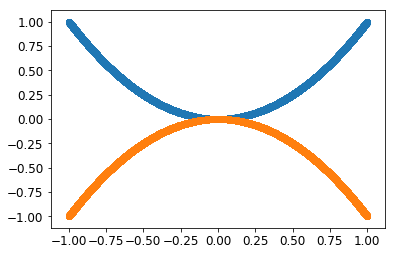

In [4]:
# Funcs to generate data
def y(x,sign=1):
    return x*x

# Data ranging from x = -0.5 to 0.5
def sample_data(n=10000, scale=100):
    data1 = []
    data2 = []
    
    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = y(x[i])
        y2i = -yi
        data1.append([x[i], yi])
        data2.append([x[i], y2i])
        
    return np.float32(np.array(data1)), np.float32(np.array(data2))


X1, X2 = sample_data(n=20000,scale=2)
train_data = np.concatenate([X1,X2],axis=1)
plt.scatter(X1[:,0], X1[:,1])
# plt.show()
plt.scatter(X2[:,0], X2[:,1])

In [7]:
from model import RoboGAN

reset_graph()

sess = tf.Session()

nDimX = X1.shape[1]
nDimY = X2.shape[1]

GAN = RoboGAN()

# Generating forward GAN = G: X -> Y
X = tf.placeholder(tf.float32, shape=(None,nDimX), name = "X")
G = GAN.generator(name="G")
G_D = GAN.discriminator(name="G_D")

# Generating backward GAN = F: Y -> X
Y = tf.placeholder(tf.float32, shape=(None, nDimY), name="Y")
F = GAN.generator(name="F")
F_D = GAN.discriminator(name="F_D")


In [9]:
# Loss for
with tf.GradientTape() as G_tape, tf.GradientTape() as G_D_tape:
    
    fake_Y = G(X)
    D_Gy_logits = G_D(fake_Y)
    D_Y_logits = G_D(Y)
    
    G_loss = GAN.generator_loss(D_Gy_logits)
    G_D_loss = GAN.discriminator_loss(real_output=D_Y_logits, fake_output=D_Gy_logits)
    
    G_gradients = G_tape.gradient(G_loss, G.trainable_variables)
    G_D_gradients = G_D_tape.gradient(G_D_loss, G_D.trainable_variables)

Instructions for updating:
Use tf.cast instead.


## Setting up optimizers

In [12]:
opt_G = tf.train.AdamOptimizer(1e-3)
opt_G_D = tf.train.AdamOptimizer(1e-3)
train_G = opt_G.apply_gradients(zip(G_gradients, G.trainable_variables))
train_G_D = opt_G_D.apply_gradients(zip(G_D_gradients, G_D.trainable_variables))

## Running the trainiong via a tensorflow session

In [ ]:
sess =  tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 100
for epoch in range(30):
    for i,batch in enumerate(shuffle_batch(train_data, batch_size)):
        X_batch = batch[:,:2]
        Y_batch = batch[:,2:]
        Gloss, GDloss,_,_ = sess.run([G_loss, G_Dloss, train_G, train_G_D], feed_dict={X:X_batch})
    
    
    print("Epoch {}: GLoss:{:.4f}, DLoss:{:.4f}".format(epoch,gloss,dloss))